# **Customer Insights from Amazon Review Data**

# Executive Summary

This project analyzes over 3 million Amazon reviews in the Clothing, Shoes, and Jewelry category to uncover actionable insights for e-commerce decision-makers. Using PySpark via GCP for scalable data processing, we explored review trends, product popularity, and rating distributions. Key findings include the identification of top-reviewed products, patterns in customer satisfaction, and unusual reviewer behavior. Building on this foundation, we applied advanced NLP techniques—such as topic modeling, sentiment analysis, and review intent classification—to gain a deeper understanding of customer needs and perceptions. These insights support data-driven strategies for product optimization, personalized marketing, and improved customer engagement across the platform.

# 1.Introduction

## 1.1 Project Overview



[Original Project Proposal](https://docs.google.com/document/d/10lPg2rToUKRga2Ud5ZlRaJwfjMCzVLFxXPML2VutDJI/edit?tab=t.0#heading=h.9gxi39pc0fk5)

This project aims to analyze customer reviews in the Amazon Clothing, Shoes & Jewelry category to extract actionable business insights. Specifically, the project will:

- Perform association rule mining to uncover product bundling and cross-selling opportunities.

- Conduct topic modeling and sentiment analysis to understand customer feedback trends across different product categories.

- Identify high-value customer segments through clustering based on review behavior and media usage patterns.

- Deliver strategic recommendations for inventory management, personalized marketing, and customer engagement improvements.


## 1.2 Data Source

The primary dataset is the Amazon Customer Reviews dataset, originally compiled from Amazon’s public review data and hosted on HuggingFace Datasets.
For this project, we specifically used the Clothing, Shoes & Jewelry subset.

- [Dataset Source](https://amazon-reviews-2023.github.io/)

## 1.3 Motivation

In today’s digital marketplace, customer reviews are a vital source of feedback that influence purchasing decisions and shape brand perception. However, without structured analysis, the vast volume of review data often remains underutilized. This project leverages the Amazon Reviews 2022 dataset, specifically the Clothing, Shoes & Jewelry category, to extract actionable insights from customer sentiment, review content, and behavioral patterns. Using a combination of exploratory data analysis, text mining, and machine learning techniques, we uncover trends in consumer satisfaction, identify high-impact product attributes, and segment reviewer behavior. These insights inform strategic decisions in product development, personalized marketing, and customer engagement—empowering businesses to respond more effectively to evolving consumer needs.

# 2. Data Setup and Initial Exploration

## 2.1 Module and Libraries Installation

In [ ]:
# ------------------------------------------------------------------------------------------------------------
# This cell contains all the libraries and modules that need to be accessed throughout the course of this EDA.
# ------------------------------------------------------------------------------------------------------------
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, FloatType, DoubleType, MapType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, year, from_unixtime, col, length
from pyspark.sql.functions import from_json, col, schema_of_json
from pyspark.sql.functions import count, desc, DataFrame
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField
from matplotlib.ticker import FuncFormatter
import tqdm


import pandas as pd
import json

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# ------------------------------------------------------------------------------------------------------
# CONFIGS : This cell contains all the configuration variables that needs to be accessed and are common.
# ------------------------------------------------------------------------------------------------------


reviews_path = "gs://ba843-group1-project/Clothing_Shoes_and_Jewelry.jsonl.gz"
reviews_output_path = "gs://ba843-group1-project/Clothing_Shoes_and_Jewelry_converted.parquet"
meta_path = "gs://ba843-group1-project/meta_Clothing_Shoes_and_Jewelry.jsonl.gz"
meta_output_path  = "gs://ba843-group1-project/meta_Clothing_Shoes_and_Jewelry_converted_shubham.parquet"
merged_output_path = "gs://ba843-group1-project/merged_review_dedup_data.parquet"
common_key = "parent_asin"
master_data_path = "gs://ba843-group1-project/master_data.parquet"
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
# --------------------------------------------------------------------------------
# UTILS: This cell contains all the utility functions that will be called for EDA.
# --------------------------------------------------------------------------------


def preprocess(text):

    """
    Preprocesses the input text by performing the following steps:
    1. Converts the text to lowercase.
    2. Removes URLs and non-alphabetic characters.
    3. Splits the text into words.
    4. Removes stop words and words with length less than or equal to 2.
    5. Lemmatizes the remaining words.

    Parameters:
        text (str): The input text to preprocess.

    Returns:
        str: The cleaned and preprocessed text.
    """

    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|[^a-z\s]", "", text)  # Remove URLs & non-letters
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)


def count_nulls(df):

    '''
    Function to count nulls for each column in a DataFrame

    Parameters :
    - df (dataframe)   : Pyspark Dataframe

    Returns:
    - py_df (dataframe) : Pyspark Dataframe containing number of null values

    '''


    py_df = df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()
    return py_df

def null_percent(df):

    '''
    Function to return %ge of nulls for each column in a DataFrame

    Input :
    - df    : Pyspark Dataframe

    Output:
    - py_df : Pyspark Dataframe containing %ge of null values
    '''


    total = df.count()
    return df.select([
        (_sum(col(c).isNull().cast("int")) / total).alias(c) for c in df.columns
    ])


def drop_duplicate_columns_rebuild(df):

    """
    Removes duplicate columns from a Spark DataFrame by rebuilding it
    using only the first occurrence of each column name.

    This function:
    1. Identifies and keeps the first occurrence of each unique column name.
    2. Creates a new schema with only the unique columns.
    3. Reconstructs the DataFrame using the cleaned schema and data.

    Parameters:
        df (pyspark.sql.DataFrame): The input Spark DataFrame possibly containing duplicate columns.

    Returns:
        pyspark.sql.DataFrame: A new DataFrame with duplicate columns removed.
    """

    fields = df.schema.fields
    seen = set()
    unique_indices = []
    unique_names = []

    for idx, field in enumerate(fields):
        name = field.name
        if name not in seen:
            seen.add(name)
            unique_indices.append(idx)
            unique_names.append(name)

    # Create a schema from the unique fields
    unique_fields = [fields[i] for i in unique_indices]
    schema = StructType(unique_fields)

    # Create new RDD of Row objects
    new_rdd = df.rdd.map(lambda row: Row(*[row[i] for i in unique_indices]))

    # Rebuild the DataFrame
    deduped_df = spark.createDataFrame(new_rdd, schema=schema)

    return deduped_df

In [ ]:
#Creating the spark session
spark = SparkSession.builder.appName("AmazonReviews").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 23:08:19 INFO SparkEnv: Registering MapOutputTracker
25/04/28 23:08:19 INFO SparkEnv: Registering BlockManagerMaster
25/04/28 23:08:19 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/04/28 23:08:20 INFO SparkEnv: Registering OutputCommitCoordinator


## 2.2 Read Dataset

In [ ]:
# This dataset contains the raw text from the reviews parquet file
review_df = spark.read.parquet(reviews_output_path)

In [ ]:
#Checking the first 5 records
print("Reviews:")
review_df.show(5, truncate=True)

Reviews:


+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|              images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B096S6LZV4|           0|[{IMAGE, https://...| B09NSZ5QMF|   3.0|Unfortunately Ama...|1677938767351|Arrived Damaged :...|AFKZENTNBQ7A7V7UX...|             true|
|B09KMDBDCN|           0|                  []| B08NGL3X17|   3.0|Useless under 40 ...|1677083819242|Useless under 40 ...|AFKZENTNBQ7A7V7UX...|            false|
|B096N5WK8Q|          11|                  []| B07RGM3DYC|   4.0|I purchased these...|1675524098918|Not waterproof, b...|AFKZENTNBQ7A7V7UX...|             true|
|B07JR4QBZ4|          26|[{IMAGE, 

In [ ]:
#Checking the number of records
num_rows = review_df.count()
num_cols = len(review_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 132066692
Number of columns: 10


In [ ]:
review_df.cache()

DataFrame[asin: string, helpful_vote: bigint, images: array<struct<attachment_type:string,large_image_url:string,medium_image_url:string,small_image_url:string>>, parent_asin: string, rating: double, text: string, timestamp: bigint, title: string, user_id: string, verified_purchase: boolean]

In [ ]:
#This dataset contains the metadata for the products that have been reviewed

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# NOTE : The original file was having a nested JSON and SPARK was crashing. We created the parquet for that locally using custom Schema andd doing in batches
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

meta_df = spark.read.parquet(meta_output_path)

In [ ]:
#Checking the first 5 records
print("Metadata:")
meta_df.show(5, truncate=True)

Metadata:


+--------------+--------------------+--------------+-------------+--------------------+--------------------+------+--------------------+--------------------+------------+--------------------+-----------+---------------+
| main_category|               title|average_rating|rating_number|            features|         description| price|              images|              videos|       store|          categories|parent_asin|bought_together|
+--------------+--------------------+--------------+-------------+--------------------+--------------------+------+--------------------+--------------------+------------+--------------------+-----------+---------------+
|AMAZON FASHION|BALEAF Women's Lo...|           4.2|        422.0|['90% Polyester, ...|                  []| 31.99|[{'thumb': 'https...|[{'title': "Women...|      BALEAF|['Clothing, Shoes...| B09X1MRDN6|           NULL|
|AMAZON FASHION|Merrell Work Moab...|           2.7|          4.0|     ['Rubber sole']|                  []|  NULL|[{'th

In [ ]:
meta_df.cache()

DataFrame[main_category: string, title: string, average_rating: double, rating_number: double, features: string, description: string, price: double, images: string, videos: string, store: string, categories: string, parent_asin: string, bought_together: string]

In [ ]:
#Checking the number of records

num_rows = meta_df.count()
num_cols = len(meta_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 7218481
Number of columns: 13


In [ ]:
# Write merged_df to Google Cloud Storage as a Parquet file
merged_df.write \
    .mode("overwrite") \      # or "append", "errorifexists", etc.
    .parquet("gs://ba843-group1-project/master_data.parquet")

## 2.3 Missing Values

In [ ]:
print("Review Data Types:")
review_df.printSchema()

print("Metadata Data Types:")
meta_df.printSchema()

Review Data Types:
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)

Metadata Data Types:
root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: double (nullable = true)
 |-- features: string (nullable = true)
 |-- description: string (nullable = true)
 |-- price: double 

In [ ]:
print("Null Counts in Metadata")
count_nulls(meta_df)
# Main Category, price, store and bought together are having missing value. Let's analyze the percentage of missing values in the column.

Null Counts in Metadata


+-------------+-----+--------------+-------------+--------+-----------+-------+------+------+-----+----------+-----------+---------------+
|main_category|title|average_rating|rating_number|features|description|  price|images|videos|store|categories|parent_asin|bought_together|
+-------------+-----+--------------+-------------+--------+-----------+-------+------+------+-----+----------+-----------+---------------+
|       929740|    0|             0|            0|       0|          0|5759247|     0|     0|45486|         0|          0|        7218481|
+-------------+-----+--------------+-------------+--------+-----------+-------+------+------+-----+----------+-----------+---------------+



In [ ]:
print("Null Percentage in Metadata")
null_percent(meta_df).show()

Null Percentage in Metadata


+-------------------+-----+--------------+-------------+--------+-----------+-----------------+------+------+--------------------+----------+-----------+---------------+
|      main_category|title|average_rating|rating_number|features|description|            price|images|videos|               store|categories|parent_asin|bought_together|
+-------------------+-----+--------------+-------------+--------+-----------+-----------------+------+------+--------------------+----------+-----------+---------------+
|0.12879995112545145|  0.0|           0.0|          0.0|     0.0|        0.0|0.797847497278167|   0.0|   0.0|0.006301325722129074|       0.0|        0.0|            1.0|
+-------------------+-----+--------------+-------------+--------+-----------+-----------------+------+------+--------------------+----------+-----------+---------------+



In [ ]:
print("Null Counts in Reviews data")
count_nulls(review_df)

# This has all the data, and there are no missing values for reviews.

Null Counts in Reviews data


+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|asin|helpful_vote|images|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|   0|           0|     0|          0|     0|   0|        0|    0|      0|                0|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+



In [ ]:
print("Null Percentage in Reviews data:")
null_percent(review_df).show()

Null Percentage in Reviews data:


+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|asin|helpful_vote|images|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
| 0.0|         0.0|   0.0|        0.0|   0.0| 0.0|      0.0|  0.0|    0.0|              0.0|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+



In [ ]:
meta_df = meta_df.withColumnRenamed("title", "Product_title")

In [ ]:
# Merging the datasets together to get a unified dataset that has the product description tagged to the review

merged_df = review_df.join(meta_df, on=[common_key], how="inner")
print ("Top 5 rows of merged data:\n")
merged_df.show(5, truncate=True)

Top 5 rows of merged data:



+-----------+----------+------------+------+------+--------------------+-------------+--------------------+--------------------+-----------------+-----------------+--------------------+--------------+-------------+--------------------+--------------------+-----+--------------------+------+------------------------------------+--------------------+---------------+
|parent_asin|      asin|helpful_vote|images|rating|                text|    timestamp|               title|             user_id|verified_purchase|    main_category|       Product_title|average_rating|rating_number|            features|         description|price|              images|videos|                               store|          categories|bought_together|
+-----------+----------+------------+------+------+--------------------+-------------+--------------------+--------------------+-----------------+-----------------+--------------------+--------------+-------------+--------------------+--------------------+-----+--------

In [ ]:
#Checking the total number of records in the dataset when merged

num_rows = merged_df.count()
num_cols = len(merged_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 132066692
Number of columns: 22


In [ ]:
merged_df.cache()

DataFrame[parent_asin: string, asin: string, helpful_vote: bigint, images: array<struct<attachment_type:string,large_image_url:string,medium_image_url:string,small_image_url:string>>, rating: double, text: string, timestamp: bigint, title: string, user_id: string, verified_purchase: boolean, main_category: string, title: string, average_rating: double, rating_number: double, features: string, description: string, price: double, images: string, videos: string, store: string, categories: string, bought_together: string]

# 3. Exploratory Data Analysis (EDA)

[Original EDA Notebook](https://drive.google.com/file/d/1UG_kKbIKdyxX0ZBdGscW5NNnBC9AHiSp/view?usp=drive_link)

Below is a streamlined version of the EDA. For the full version, please refer to the link above.

## 3.1 Non-duplicated Records

In [ ]:
#Checking duplicates (Logic: Same user_id at the same product asin cannot have same multiple comments at the same timestamp)

duplicate_comments_pivot = merged_df.groupBy(["user_id", "asin", "timestamp"]) \
         .agg(count("*").alias("count_duplicated")) \
         .filter("count_duplicated > 1") \
         .orderBy(desc("count_duplicated"))

In [ ]:
duplicate_comments_pivot.cache()

DataFrame[user_id: string, asin: string, timestamp: bigint, count_duplicated: bigint]

In [ ]:
duplicate_count = duplicate_comments_pivot.count()
print(f"Number of duplicate comments: {duplicate_count}")

Number of duplicate comments: 65346148


In [ ]:
# Since there are a lot of duplicated by user_id for the same product at the same time, we are dropping the duplicates to keep only one record
deduped_df = merged_df.dropDuplicates()

In [ ]:
# Dropping duplicate columns (Columns common to both metadata and reviews data.
clean_df = drop_duplicate_columns_rebuild(deduped_df)

In [ ]:
clean_df.cache()

DataFrame[parent_asin: string, asin: string, helpful_vote: bigint, images: array<struct<attachment_type:string,large_image_url:string,medium_image_url:string,small_image_url:string>>, rating: double, text: string, timestamp: bigint, title: string, user_id: string, verified_purchase: boolean, main_category: string, Product_title: string, average_rating: double, rating_number: double, features: string, description: string, price: double, videos: string, store: string, categories: string, bought_together: string]

In [ ]:
#Saving the cleaned data for future reference to save on memory

clean_df.write.mode("overwrite").parquet(master_data_path)

In [ ]:
# Writing the data to bucket

clean_df = spark.read.parquet(master_data_path)

In [ ]:
print ("Total rows after removing duplicates:\n")
clean_df.count()

Total rows after removing duplicates:



65346226

## 3.2 Distribution of Ratings

/tmp/ipykernel_149232/1352409049.py:12: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=rating_pd, x="rating", y="count", palette="Blues_d")


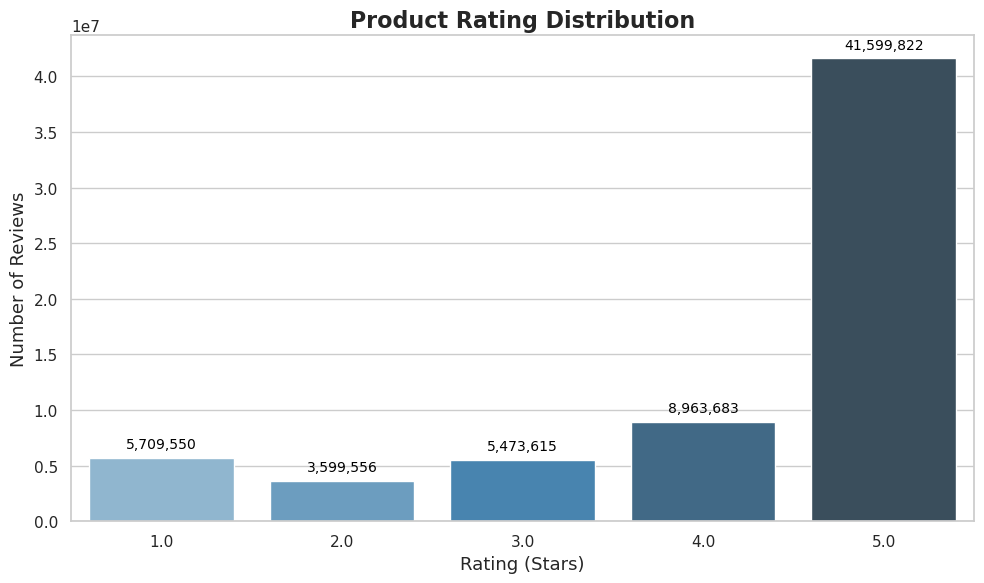

In [ ]:
rating_counts = clean_df.groupBy("rating").count().orderBy("rating")
rating_pd = rating_counts.toPandas()

sns.set(style="whitegrid", context="notebook")

plt.figure(figsize=(10, 6))

# Draw the barplot
ax = sns.barplot(data=rating_pd, x="rating", y="count", palette="Blues_d")

# Adding value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height):,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title("Product Rating Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Rating (Stars)", fontsize=13)
plt.ylabel("Number of Reviews", fontsize=13)

# Customizing ticks
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Adding gridlines to Y-axis
ax.yaxis.grid(True)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


Insights from the chart above:

- 5-star reviews dominate, indicating overwhelmingly positive customer feedback.

- Low counts of 1- and 2-star reviews suggest a strong positivity bias.

- Review counts increase steadily with rating, peaking sharply at 5 stars.

- The distribution is heavily right-skewed, showing disproportionate favor toward high ratings.

- Such skewed data may mask true product quality, warranting deeper sentiment analysis.

## 3.3 Number of Reviews Over Time

In [ ]:
reviews_by_year = clean_df.withColumn("year", year(from_unixtime(col("timestamp")/1000))) \
                           .groupBy("year") \
                           .count() \
                           .orderBy("year")

In [ ]:
reviews_by_year.cache()

DataFrame[year: int, count: bigint]

In [ ]:
reviews_by_year_pd = reviews_by_year.toPandas()

In [ ]:
reviews_by_year_pd["yoy_change"] = reviews_by_year_pd["count"].pct_change() * 100

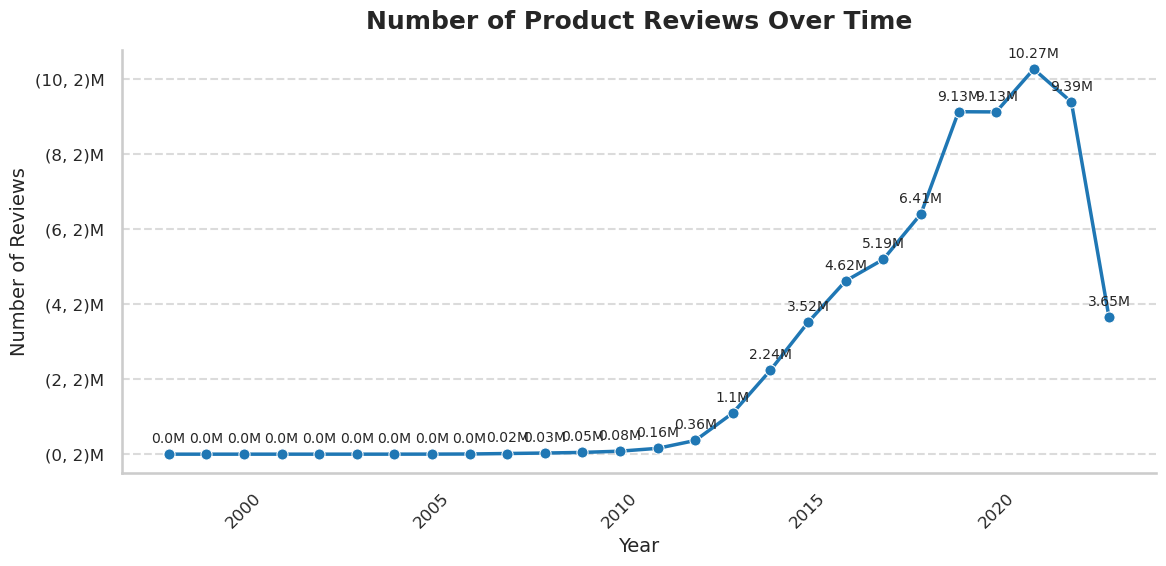

In [ ]:
sns.set(style="whitegrid", context="talk")

# Define figure size
plt.figure(figsize=(12, 6))

ax = sns.lineplot(
    data=reviews_by_year_pd,
    x="year",
    y="count",
    marker="o",
    linewidth=2.5,
    markersize=8,
    color="#1f77b4"
)

formatter = FuncFormatter(lambda x, _: f'{round(x/1000000),2}M')
ax.yaxis.set_major_formatter(formatter)

for x, y in zip(reviews_by_year_pd["year"], reviews_by_year_pd["count"]):
    ax.annotate(f'{round((y/1000000),2)}M', xy=(x, y), textcoords="offset points", xytext=(0, 8),
                ha='center', fontsize=10)

# Title and axis labels
plt.title("Number of Product Reviews Over Time", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(False)
ax.set_axisbelow(True)
sns.despine()
plt.tight_layout()

plt.show()


Insights from the chart above:

- Product reviews grew slowly until 2011, after which they began rising sharply.

- 2011–2020 saw rapid growth, peaking at 10.27 million reviews in 2020.

- Post-2020, review counts declined, suggesting saturation or behavioral shifts.

- 2023 review volume dropped significantly, falling to just 3.65 million (needs to be investigated, might be limited number of days of 2023 taken into consideration).

- This trend reflects a boom during the pandemic years, followed by a slight cooldown.

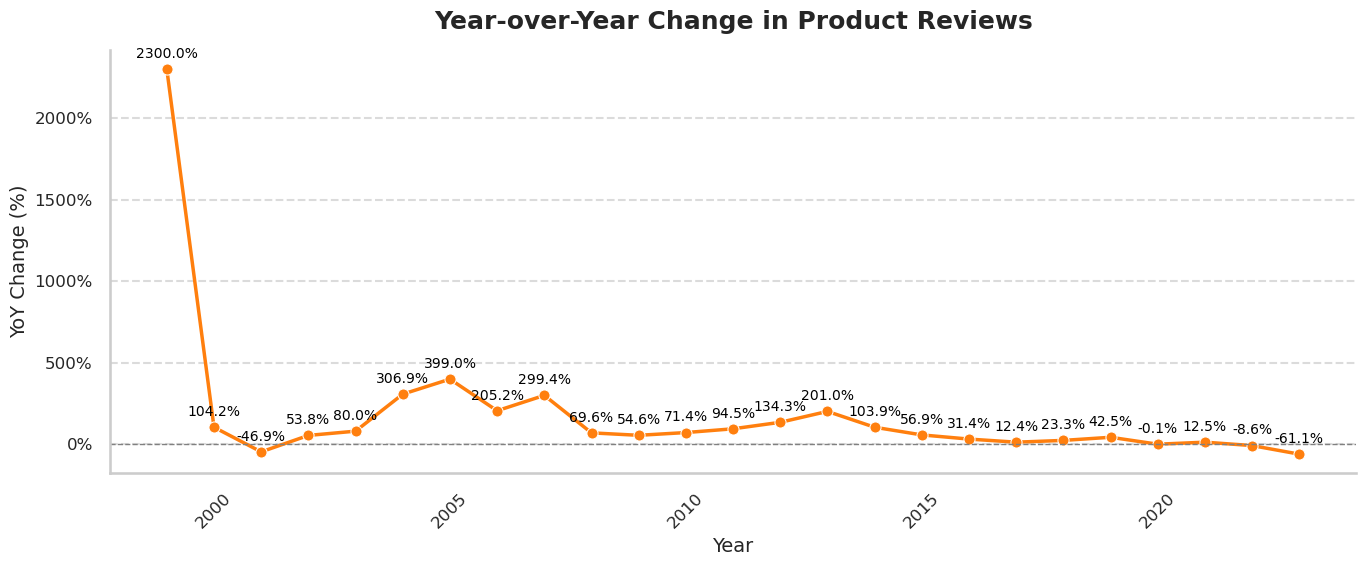

In [ ]:
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 6))
ax = sns.lineplot(
    data=reviews_by_year_pd,
    x="year",
    y="yoy_change",
    marker="o",
    linewidth=2.5,
    markersize=8,
    color="#ff7f0e"
)

# Formatting y-axis as percentages
formatter = FuncFormatter(lambda x, _: f'{x:.0f}%')
ax.yaxis.set_major_formatter(formatter)

# Annotating each point with YoY %
for x, y in zip(reviews_by_year_pd["year"], reviews_by_year_pd["yoy_change"]):
    if pd.notnull(y):
        ax.annotate(f'{y:.1f}%', xy=(x, y), textcoords="offset points", xytext=(0, 8),
                    ha='center', fontsize=10, color="black")

plt.title("Year-over-Year Change in Product Reviews", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=14)
plt.ylabel("YoY Change (%)", fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

ax.axhline(0, linestyle="--", color="gray", linewidth=1)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(False)
ax.set_axisbelow(True)
sns.despine()
plt.tight_layout()
plt.show()


Insights:

- Early 2000s had volatile YoY spikes, typical of platforms gaining traction.

- The highest YoY growth was in 2000 at 2300%, from a very low base.

- From 2010–2017, growth remained positive and steady, indicating healthy adoption.

- YoY growth dipped below 0% after 2020, signaling a slowdown.

- The sharp -61.1% decline in 2023 marks the steepest drop in review activity (needs to be investigated, might be limited number of days of 2023 taken into consideration).



## 3.4 Distribution of Review Lengths

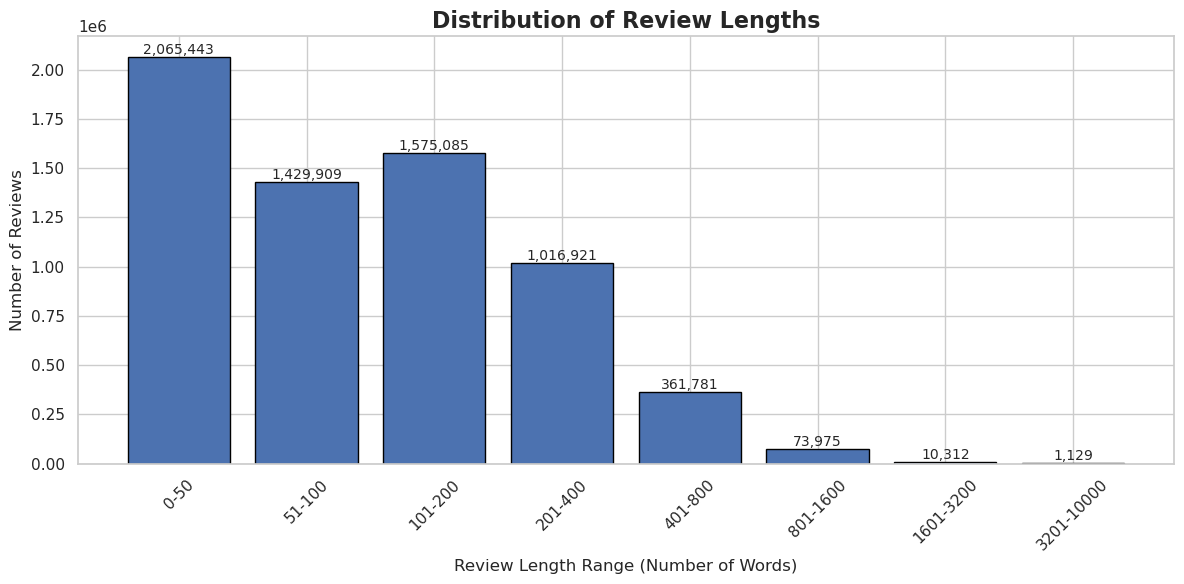

In [ ]:
sns.set(style="whitegrid")

# Defining custom labels for the bins
bin_labels = ['0-50', '51-100', '101-200', '201-400', '401-800', '801-1600', '1601-3200', '3201-10000']

# Cutting and labeling the bins
bins = [0, 50, 100, 200, 400, 800, 1600, 3200, 10000]
length_pd["length_bin"] = pd.cut(length_pd["text_length"], bins=bins, labels=bin_labels)

# Counting values
length_bin_counts = length_pd["length_bin"].value_counts().sort_index()


plt.figure(figsize=(12, 6))
bars = plt.bar(length_bin_counts.index, length_bin_counts.values, color=sns.color_palette("deep")[0], edgecolor='black')

# Adding value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height:,}',
             ha='center', va='bottom', fontsize=10)

# Titles and labels
plt.title("Distribution of Review Lengths", fontsize=16, fontweight='bold')
plt.xlabel("Review Length Range (Number of Words)", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Insights from the chart above:

- Short reviews (0–50 words) dominate, with over 2 million entries, making them the most common.

- Review frequency steadily decreases as length increases, showing a preference for concise feedback.

- Very long reviews (800+ words) are extremely rare, making up only a tiny fraction of total reviews.

In [ ]:
spark.stop()

# 4. Association Rule Mining

For the association rule mining analysis, please refer to the [notebook](https://drive.google.com/file/d/1v1-mkfPi5LoC00PxZ7-WYbdYuNkznXU4/view?usp=drive_link) here.

# 5. Text Analysis

For the text mining analysis, please refer to the [notebook](https://drive.google.com/file/d/1eiWXh77_Q2eZScnB4wdhrX9X0iRC_SA6/view?usp=sharing) here.

# 6. Customer Clustering

For the customer clustering analysis, please refer to the [notebook](https://drive.google.com/file/d/1yX-ALjRZhvqFvghadWJKKiFsbrS37IAy/view?usp=sharing) here.

# 7. Conclusion and Future Work

## 7.1 Conclusion

Through advanced analysis of Amazon’s Clothing, Shoes & Jewelry review data, we uncovered critical business insights across three major areas:

1. Association Rule Mining
- Identified high-confidence product bundles, such as pairing swim trunks with matching rashguards (lift = 77x) and combining graphic apparel items.


- Insights support launching strategic bundles, cross-sell promotions, and targeted marketing campaigns like “Swim Essentials” or “Graphic Apparel Week.”


- Recommendation: Dynamically recommend frequently paired products on item pages and feature bundled deals to boost basket size and customer satisfaction.


2. Text Analysis
- Topic modeling and sentiment analysis revealed category-specific customer concerns, including fit and fabric issues in apparel, battery life in electronics, and assembly clarity in home goods.


- Approximately 60% of reviews were positive, but a significant portion (~20–25%) highlighted actionable pain points.


- Recommendation: Improve product detail pages (e.g., size badges, upgraded materials, clearer assembly instructions) and deploy sentiment-driven marketing that showcases highly praised features while addressing common complaints.


3. Customer Clustering
- Segmented reviewers into eight actionable customer personas based on helpfulness and media usage, such as “High-Help Multimedia Champions” and “Pure Text Reviewers.”


- Each segment exhibited distinct behaviors, offering opportunities for tailored engagement: photo contests for image-heavy reviewers, guided review prompts for low-helpfulness groups, and loyalty programs for top contributors.


- Recommendation: Personalize user communications, optimize review collection strategies, and promote user-generated content from high-value segments to enhance community trust and brand advocacy.


Together, these insights provide a data-driven blueprint for boosting customer engagement, optimizing product offerings, and strategically enhancing marketing efforts across Amazon’s e-commerce ecosystem.



## 7.2 Next Steps

Customer reviews offer a wealth of untapped insights beyond initial exploratory analysis. As next steps, we propose extending our study to build predictive models and deepen customer understanding through more advanced techniques.

* Predict Review Helpfulness
  * Develop a supervised model to predict the helpfulness of customer reviews based on features such as sentiment, review length, and reviewer behavior.

* Apply Fine-Tuned Language Models
  * Enhance sentiment and topic extraction by fine-tuning transformer-based NLP models (e.g., BERT) specifically for e-commerce review data.

* Conduct Time-Series Sentiment Analysis
  * Analyze changes in customer sentiment over time to uncover seasonal trends, product lifecycle issues, and evolving consumer needs.

# 8. Appendix

## 8.1 Challenges

While working with the Amazon Reviews dataset (132 million rows × 23 columns), we encountered several infrastructure and processing challenges. Here’s how we addressed them:

- Dataset Scale
  *   Challenge: The full dataset was too large for quick exploratory analysis.
  *   Solution: We created a stratified sample for EDA and reserved the full dataset for final modeling.

- Cluster Crashes and Memory Limits
  *   Challenge: The Jupyter kernel kept crashing during large joins and aggregations on a single-node Dataproc cluster.
  *   Solution: We migrated to a multi-node cluster (master + 3 workers) to distribute the load, reducing crashes, although memory pressure still persisted.

- YARN Resource Failures
  *   Challenge: ML pipelines (VectorAssembler → PCA → modeling) required large memory blocks, triggering frequent “Container killed by YARN” errors.
  *   Solution: We increased executor memory, enabled dynamic resource allocation, and stabilized long-running jobs.

- JupyterLab Gateway Errors
  *   Challenge: The JupyterLab interface failed (HTTP 500, java.io.IOException).
  *   Solution: We deleted the faulty cluster and provisioned a new clean cluster, restoring access.

- Blocked Outbound Traffic
  *   Challenge: The new cluster couldn’t pip install Python packages due to outbound (egress) traffic restrictions.
  *   Solution: We attached the subnet to a Cloud NAT gateway and restored HTTPS access.

- JupyterLab Gateway Errors
  *   Challenge: A single 5,000-line notebook consumed >6GB RAM just to render.
  *   Solution: We split the workflow into four smaller notebooks (EDA, feature engineering, modeling, evaluation), improving load times by ~60% and cutting memory use.

## 8.2 Generative AI Disclosure

In completing this project, we have utilized Generative AI tools to assist with various aspects of our work. Below is a detailed account of how these tools were used:

- Content Generation: We used ChatGPT to brainstorm ideas and structure the initial outline of the project. The AI helped us refine our thesis statement and suggested key points to include in each section.

- Research Assistance: ChatGPT was used to summarize research articles and generate concise overviews of relevant topics, helping us better understand and integrate complex concepts.

- Code Review and Debugging: GitHub Copilot and ChatGPT suggested ways to improve our Python code, including optimizing algorithms and resolving potential errors.

- Proofreading and Grammar Checks: We used Grammarly to refine our writing, improve readability, and ensure grammatical accuracy.

Our team has reviewed, edited, and validated all AI-generated content to ensure its accuracy, relevance, and originality in accordance with academic integrity guidelines.
